In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

from scipy import signal
from scipy.signal import find_peaks
from scipy.integrate import cumtrapz

from datetime import datetime

import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import sqlite3

import math

In [21]:
# サンプリングレート(0.015秒に1回)
sampling_rate = 66

filter_num = sampling_rate * 1

In [22]:
class Data:
    def __init__(self, folder_name):
        self.folder_name = "data/" + folder_name
        self.path = folder_name
        self.file_names = os.listdir(self.folder_name)

        self.start_time = None
        self.end_time = None

        self.weighting_factor = 1

        # acceleration.csvがない場合は作成する
        if "acceleration.csv" not in self.file_names:
            self.make_acceleration()
            self.file_names = os.listdir(self.folder_name)

        # 'all.csv'がある場合は削除する
        if "all.csv" in self.file_names:
            self.file_names.remove("all.csv")

        self.df = pd.DataFrame()
        for file_name in self.file_names:
            df_tmp = pd.read_csv(os.path.join(self.folder_name, file_name))
            file_type = file_name.replace(".csv", "")

            # 列名を変更してファイル名を追加
            df_tmp = df_tmp.rename(
                columns={
                    "x": file_type + "_x",
                    "y": file_type + "_y",
                    "z": file_type + "_z",
                }
            )

            # 'rotate.csv' に 'w' 列がある場合は削除
            if "w" in df_tmp.columns and file_name == "rotate.csv":
                df_tmp = df_tmp.drop(["w"], axis=1)

            if type(df_tmp["time"][0]) == int:
                # 'time'列の変換を実行
                df_tmp["time"] = df_tmp["time"] / 1000
                df_tmp["time"] = pd.to_datetime(df_tmp["time"], unit="s")

            # df_tmpをdfに追記する,既にある列名は追記しない
            self.df = pd.concat([self.df, df_tmp], axis=1, sort=False)

            # 呼び出したファイルに上書き保存する
            df_tmp.to_csv(os.path.join(self.folder_name, file_name), index=False)

        # 1行目のtime列以外のtime列を削除する
        self.df = self.df.iloc[
            :,
            [0]
            + [
                i
                for i in range(1, len(self.df.columns))
                if not self.df.columns[i].startswith("time")
            ],
        ]
        self.df["time"] = pd.to_datetime(self.df["time"] / 1000, unit="s")

        # csvファイルを出力する
        self.df.to_csv(os.path.join(self.folder_name, "all.csv"), index=False)

    def make_acceleration(self):
        df_tmp = pd.read_csv(os.path.join(self.folder_name, "velocity.csv"))
        df_acc = df_tmp
        # df_tmpからx,y,z列を削除する
        df_acc = df_acc.drop(["x", "y", "z"], axis=1)
        df_acc["x"] = df_tmp["x"].cumsum()
        df_acc["y"] = df_tmp["y"].cumsum()
        df_acc["z"] = df_tmp["z"].cumsum()
        df_acc.to_csv(os.path.join(self.folder_name, "acceleration.csv"), index=False)
        df_acc = df_acc.drop(["time"], axis=1)
        df_acc["acceleration_x"] = df_acc["x"]
        df_acc["acceleration_y"] = df_acc["y"]
        df_acc["acceleration_z"] = df_acc["z"]
        df_acc = df_acc.drop(["x", "y", "z"], axis=1)
        self.df = pd.concat([self.df, df_acc], axis=1, sort=False)
        return self

    def low_filter(self, column_type, n):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.low_filter(column, n)
        else:
            column = column_type + "_x"
            out_column = column_type + "_low_x"
            self.df[out_column] = self.df[column].rolling(n, center=True).mean()
            column = column_type + "_y"
            out_column = column_type + "_low_y"
            self.df[out_column] = self.df[column].rolling(n, center=True).mean()
            column = column_type + "_z"
            out_column = column_type + "_low_z"
            self.df[out_column] = self.df[column].rolling(n, center=True).mean()
        return self

    def high_filter(self, column_type, n):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.high_filter(column, n)
        else:
            column = column_type + "_x"
            out_column = column_type + "_high_x"
            self.df[out_column] = (
                self.df[column] - self.df[column].rolling(n, center=False).mean()
            )
            column = column_type + "_y"
            out_column = column_type + "_high_y"
            self.df[out_column] = (
                self.df[column] - self.df[column].rolling(n, center=False).mean()
            )
            column = column_type + "_z"
            out_column = column_type + "_high_z"
            self.df[out_column] = (
                self.df[column] - self.df[column].rolling(n, center=False).mean()
            )
        return self

    def diff(self, column_type):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.diff(column)
        else:
            column = column_type + "_x"
            out_column = column_type + "_diff_x"
            self.df[out_column] = self.df[column].diff()
            column = column_type + "_y"
            out_column = column_type + "_diff_y"
            self.df[out_column] = self.df[column].diff()
            column = column_type + "_z"
            out_column = column_type + "_diff_z"
            self.df[out_column] = self.df[column].diff()
        return self

    def reverse(self, column_type):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.reverse(column)
        else:
            column = column_type + "_x"
            out_column = column_type + "_reverse_x"
            self.df[out_column] = self.df[column] * -1
            column = column_type + "_y"
            out_column = column_type + "_reverse_y"
            self.df[out_column] = self.df[column] * -1
            column = column_type + "_z"
            out_column = column_type + "_reverse_z"
            self.df[out_column] = self.df[column] * -1
        return self

    def non_minus(self, column_type):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.non_minus(column)
        else:
            column = column_type + "_x"
            out_column = column_type + "_non_minus_x"
            self.df[out_column] = [x * -1 if x < 0 else x for x in self.df[column]]
            column = column_type + "_y"
            out_column = column_type + "_non_minus_y"
            self.df[out_column] = [x * -1 if x < 0 else x for x in self.df[column]]
            column = column_type + "_z"
            out_column = column_type + "_non_minus_z"
            self.df[out_column] = [x * -1 if x < 0 else x for x in self.df[column]]
        return self

    def shift_minus(self, column_type):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.shift_minus(column)
        else:
            column = column_type + "_x"
            out_column = column_type + "_shift_minus_x"
            self.df[out_column] = self.df[column].apply(lambda x: 0 if x < 0 else x)
            column = column_type + "_y"
            out_column = column_type + "_shift_minus_y"
            self.df[out_column] = self.df[column].apply(lambda x: 0 if x < 0 else x)
            column = column_type + "_z"
            out_column = column_type + "_shift_minus_z"
            self.df[out_column] = self.df[column].apply(lambda x: 0 if x < 0 else x)
        return self

    def cumsum(self, column_type):
        if column_type == "all":
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    pass
                self.cumsum(column)
        else:
            column_x = column_type + "_x"
            out_column_x = column_type + "_cumsum_x"
            self.df[out_column_x] = self.df[column_x].cumsum()
            column_y = column_type + "_y"
            out_column_y = column_type + "_cumsum_y"
            self.df[out_column_y] = self.df[column_y].cumsum()
            column_z = column_type + "_z"
            out_column_z = column_type + "_cumsum_z"
            self.df[out_column_z] = self.df[column_z].cumsum()
        return self
    
    def complementary(self, column_type):
        # column_type に angularVelocity が含まれていない場合は処理を行わない
        if "angularVelocity" not in column_type or "cumsum" not in column_type or "_y" not in column_type:
            print("不適切な入力です")
            return self
        out_column = column_type.replace("_y", "_complementary_y")
        self.df[out_column] = self.df[column_type] * self.weighting_factor + np.arctan2(self.df["acceleration_x"],self.df["acceleration_y"]) * (1 - self.weighting_factor)
        return self

    def plot(self, column_type, option, axis):
        self.i = 0
        self.fig = plt.figure(figsize=(15, 25))

        if column_type == "all":
            # 'all.csv'がある場合は削除する
            for column in self.file_names:
                column = column.replace(".csv", "")
                if column == "all":
                    continue
                self.ax(column, option, axis)
                self.i += 1
        else:
            column_type = column_type.replace(".csv", "")
            self.ax(column_type, option, axis)
        plt.show()

    def ax(self, column_type, option, axis):
        self.low_filter(column_type, filter_num)
        ax = self.fig.add_subplot(5, 1, self.i + 1)
        match option:
            case "axvspan":
                self.axvspan(column_type)
            case "diff":
                column_type = column_type + "_diff"
            case "high":
                column_type = column_type + "_high"
            case "low":
                column_type = column_type + "_low"
            case "reverse":
                column_type = column_type + "_reverse"
            case "shift_minus":
                column_type = column_type + "_shift_minus"
            case "reverse":
                column_type = column_type + "_reverse"
            case "non_minus":
                column_type = column_type + "_non_minus"
            case "cumsum":
                column_type = column_type + "_cumsum"
            case "complementary":
                column_type = column_type + "_complementary"
        match axis:
            case "x":
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_x"],
                    label=column_type + "_x",
                )
            case "y":
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_y"],
                    label=column_type + "_y",
                )
            case "z":
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_z"],
                    label=column_type + "_z",
                )
            case _:
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_x"],
                    label=column_type + "_x",
                )
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_y"],
                    label=column_type + "_y",
                )
                ax.plot(
                    self.df["time"],
                    self.df[column_type + "_z"],
                    label=column_type + "_z",
                )
        ax.legend()
        # タイトル
        ax.set_title(column_type)
        ax.set_xlabel("time")
        ax.set_ylabel(column_type)
        ax.grid()

    def axvspan(self, column_type):
        ax.axvspan(self.start_time, self.end_time, color="red", alpha=0.5)

    def split_time(self, start_time, end_time):
        self.df = self.df[
            (self.df["time"] >= start_time) & (self.df["time"] <= end_time)
        ]
        return self
    
    def set_weighting_factor(self, weighting_factor):
        self.weighting_factor = weighting_factor
        return self

In [23]:
# free_walkのデータを読み込む
free_walk = Data("nishi_stairs")
free_walk.low_filter("all", filter_num)

In [24]:
# 時間をシフトする
# start 07:31:00
# end 07:34:00
start_time = datetime(2023, 12, 22, 7, 31, 25)
end_time = datetime(2023, 12, 22, 7, 34, 15)

free_walk.split_time(start_time, end_time)

# indexをリセットする
free_walk.df = free_walk.df.reset_index(drop=True)

In [47]:
# 角速度
free_walk.weighting_factor = 0.98
free_walk.cumsum("angularVelocity")
free_walk.complementary("angularVelocity_cumsum_y")

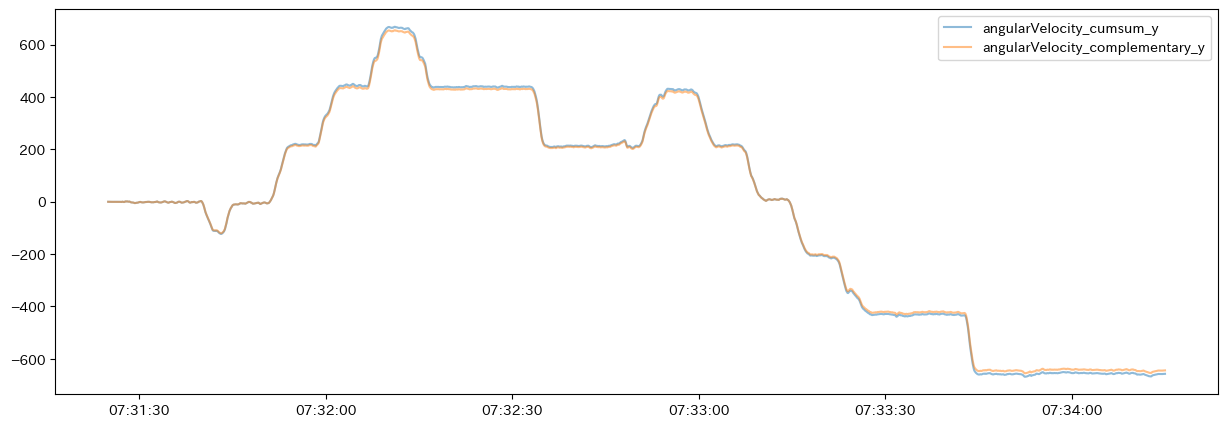

In [49]:
# cumsum と complementary を重ねて表示
fig = plt.figure(figsize=(15, 5))
# それぞれ半透明
plt.plot(free_walk.df["time"], free_walk.df["angularVelocity_cumsum_y"], label="angularVelocity_cumsum_y", alpha=0.5)
plt.plot(free_walk.df["time"], free_walk.df["angularVelocity_cumsum_complementary_y"], label="angularVelocity_complementary_y", alpha=0.5)
plt.legend()
plt.show()